In [197]:
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
import pandas as pd

In [198]:
gdf = gpd.read_file("VA_County_CityFixed2.json")

In [199]:
gdf.head(1)

,County,geometry
0,Accomack County,"POLYGON ((-75.62204 37.45679, -75.62465 37.457..."


In [200]:
# fix Fairfax County

In [201]:
gdf[gdf["County"] == "Fairfax County"]

,County,geometry
38,Fairfax County,"MULTIPOLYGON (((-77.11989 38.93430, -77.11990 ..."


In [202]:
gdf[gdf["County"] == "Fairfax City"]

,County,geometry
37,Fairfax City,"POLYGON ((-77.30314 38.86921, -77.30307 38.869..."


In [203]:
g1 = gdf[gdf["County"] == "Fairfax County"]["geometry"].iloc[-1]

In [204]:
g2 = gdf[gdf["County"] == "Fairfax City"]["geometry"].iloc[-1]

In [205]:
shape = Polygon([s for s in g1][-2:-1][0])

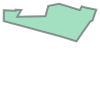

In [206]:
shape

In [207]:
g2 = MultiPolygon([g2, shape])

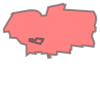

In [208]:
g2

In [209]:
new = gpd.GeoDataFrame([[g1],[g2]], columns=["geometry"])

In [210]:
new.to_file("test_hole.json", driver="GeoJSON")

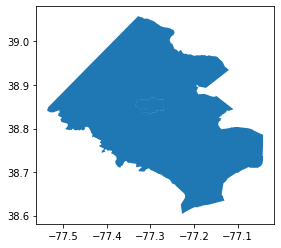

In [211]:
new.plot()

In [212]:
new

,geometry
0,"MULTIPOLYGON (((-77.11989 38.93430, -77.11990 ..."
1,"MULTIPOLYGON (((-77.30314 38.86921, -77.30307 ..."


In [213]:
g = new.iloc[0]["geometry"]

In [214]:
new["County"] = ""

In [215]:
new.at[0, "County"] = "Fairfax County"
new.at[1, "County"] = "Fairfax City"

In [216]:
new

,geometry,County
0,"MULTIPOLYGON (((-77.11989 38.93430, -77.11990 ...",Fairfax County
1,"MULTIPOLYGON (((-77.30314 38.86921, -77.30307 ...",Fairfax City


In [217]:
def parse(gdf, arg_i, arg_shape_id, arg_polygon_id):
    columns = ["geovertex_id", "shape_id", "polygon_id", "County", "x_pos", "y_pos"]
    df = pd.DataFrame(columns=columns)

    counter = 0
    i = arg_i
    shape_id = arg_shape_id
    polygon_id = arg_polygon_id

    for index, row in gdf.iterrows():
        # for visualization only
        if counter%15==0:
            print(" {:.2f}% ".format(counter/len(gdf)*100), end="")
        else:
            print("#", end="")

        cur_shape = row["geometry"]
        cur_type = type(cur_shape)

        row = row.drop(["geometry"])
        cur_row = row
        cur_row["shape_id"] = shape_id
        shape_id += 1

        if cur_type == MultiPolygon:
            for polygon in cur_shape:
                cur_row["polygon_id"] = polygon_id
                polygon_id += 1
                for coords in polygon.exterior.coords:
                    cur_row["geovertex_id"] = i
                    i += 1
                    cur_row["x_pos"] = coords[0]
                    cur_row["y_pos"] = coords[1]
                    df = df.append(cur_row, ignore_index=True)
                    cur_row = row
        elif cur_type == Polygon:
            cur_row["polygon_id"] = polygon_id
            polygon_id += 1
            for coords in cur_shape.exterior.coords:
                cur_row["geovertex_id"] = i
                i += 1
                cur_row["x_pos"] = coords[0]
                cur_row["y_pos"] = coords[1]
                df = df.append(cur_row, ignore_index=True)
                cur_row = row
        counter += 1
        
    return df

In [218]:
next_i, next_shape, next_poly = 2990000, 1, 3995

gdf_Parsed = parse(new, arg_i=next_i, arg_shape_id=next_shape, arg_polygon_id=next_poly)

gdf_Parsed.to_csv("County_VA_test.csv", index=False)

next_i = gdf_Parsed.iloc[-1]["geovertex_id"] + 1
next_shape = gdf_Parsed.iloc[-1]["shape_id"] + 1
next_poly = gdf_Parsed.iloc[-1]["polygon_id"] + 1
print("\nLast row id: geo:{}, shape:{}, poly:{}".format(gdf_Parsed.iloc[-1]["geovertex_id"],
                                                     gdf_Parsed.iloc[-1]["shape_id"],
                                                     gdf_Parsed.iloc[-1]["polygon_id"]))
print("Next id: geo:{}, shape:{}, poly:{}".format(next_i, next_shape, next_poly))

 0.00% #
Last row id: geo:3007488, shape:2, poly:3999
Next id: geo:3007489, shape:3, poly:4000
